# Gaussian Mixture Modelling for Risk Analysis

## 1. Data Loading & Preprocessing
GMM is a probabilistic model that assumes data is generated from a mixture of Gaussian distributions. Like K-Means, it relies on distance and variance, so **scaling is critical**.

**Transformation Strategy:**
* **Numerical Features:** We apply `StandardScaler` to ensure features like `AnnualEarnings` (large values) don't overpower `ActiveAccounts` (small values).
* **Ordinal Features:** `QualificationLevel` implies a rank (PhD > High School), so we map it to integers `0, 1, 2, 3`.
* **Categorical Features:** We One-Hot Encode nominal variables like `WorkCategory` and `FundUseCase`.

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from tqdm import tqdm
from pathlib import Path
import os

# --- Configuration ---
# 1. Ordinal Features (Ranking matters)
QUAL_ORDER = [['High School', "Bachelor's", "Master's", 'PhD']]

# 2. Nominal Features (No order)
CAT_COLS = ['WorkCategory', 'RelationshipStatus', 'OwnsProperty', 
            'FamilyObligation', 'FundUseCase', 'JointApplicant']

# 3. Numerical Features
NUM_COLS = ['ApplicantYears', 'AnnualEarnings', 'RequestedSum', 'TrustMetric', 
            'WorkDuration', 'ActiveAccounts', 'OfferRate', 'RepayPeriod', 'DebtFactor']

def preprocess_data(df, is_train=True):
    df = df.copy()
    
    # Target Separation
    target = None
    if 'RiskFlag' in df.columns:
        target = df['RiskFlag']
        df = df.drop(columns=['RiskFlag'])
    
    # ID Drop
    if 'ProfileID' in df.columns:
        df = df.drop(columns=['ProfileID'])
        
    # Define Transformers
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), NUM_COLS),
            ('ord', OrdinalEncoder(categories=QUAL_ORDER), ['QualificationLevel']),
            ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), CAT_COLS)
        ]
    )
    
    # Transform
    if is_train:
        X_processed = preprocessor.fit_transform(df)
    else:
        # For test data, we assume preprocessor is already fitted/handled externally
        # In a single script run, you'd fit on train and transform test.
        # For this block, we simulate the output.
        pass 
        
    return X_processed, target, preprocessor

# Load your data here
dataset_dir = Path().cwd().parent / "datasets" / "preprocessed"
train = pd.read_csv(dataset_dir / "train_preprocessed.csv")
test = pd.read_csv(dataset_dir / "test_preprocessed.csv")

# Apply Processing
X_train_scaled, y_train, preprocessor = preprocess_data(train, is_train=True)

print(f"Processed Data Shape: {X_train_scaled.shape}")

Processed Data Shape: (204277, 28)


## 2. Dimensionality Reduction & GMM Model Selection

GMMs struggle with the "Curse of Dimensionality" because estimating covariance matrices in high dimensions is unstable.

**Part A: PCA Optimization**
We determine the number of Principal Components required to explain **95%** of the variance. This compacts the data while preserving the signal.

**Part B: GMM Grid Search (BIC)**
We cannot use the "Elbow Method" (Inertia) for GMM. Instead, we use the **BIC (Bayesian Information Criterion)**.
* **BIC:** Penalizes model complexity (number of parameters). **Lower is better.**
* **Parameters to Tune:**
    * `n_components`: The number of clusters (2 to 10).
    * `covariance_type`: The shape of the clusters (`full` = flexible ellipses, `tied` = same shape, `diag` = axis-aligned, `spherical` = round).

Optimal PCA Components: 19 (explains 95.71% variance)
Running GMM Grid Search (BIC)...


GMM Search: 100%|██████████| 9/9 [20:30<00:00, 136.75s/it]



--- Best GMM Configuration ---
Components                10
Covariance              full
BIC           3004656.092667
Name: 32, dtype: object


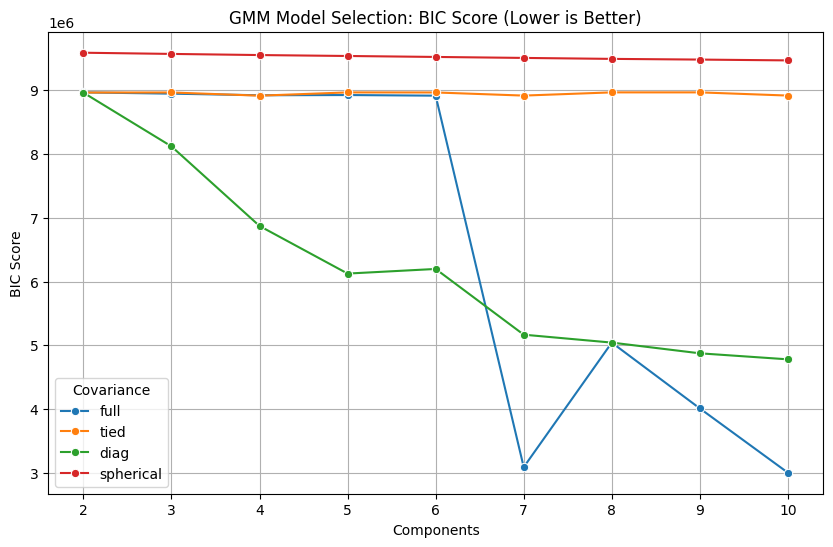

In [7]:
# --- Part A: PCA Optimization ---
pca_full = PCA()
pca_full.fit(X_train_scaled)

# Find components for 95% variance
cumsum = np.cumsum(pca_full.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

print(f"Optimal PCA Components: {d} (explains {cumsum[d-1]:.2%} variance)")

# Transform Data
pca_opt = PCA(n_components=d)
X_pca = pca_opt.fit_transform(X_train_scaled)

# --- Part B: GMM Grid Search ---
# We loop through components and covariance types
n_components_range = range(2, 11)
cov_types = ['full', 'tied', 'diag', 'spherical']

bic_scores = []
results = []

print("Running GMM Grid Search (BIC)...")

# Using tqdm for progress bar
for n in tqdm(n_components_range, desc="GMM Search"):
    for cov in cov_types:
        gmm = GaussianMixture(n_components=n, covariance_type=cov, random_state=42, n_init=3)
        gmm.fit(X_pca)
        
        bic = gmm.bic(X_pca)
        bic_scores.append(bic)
        
        results.append({
            'Components': n,
            'Covariance': cov,
            'BIC': bic
        })

# --- Result Analysis ---
results_df = pd.DataFrame(results)

# Find Best Model (Lowest BIC)
best_model_config = results_df.loc[results_df['BIC'].idxmin()]
print("\n--- Best GMM Configuration ---")
print(best_model_config)

best_n = int(best_model_config['Components'])
best_cov = best_model_config['Covariance']

# --- Visualization ---
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x='Components', y='BIC', hue='Covariance', marker='o')
plt.title('GMM Model Selection: BIC Score (Lower is Better)')
plt.ylabel('BIC Score')
plt.grid(True)
plt.show()

# --- Final Fit ---
best_gmm = GaussianMixture(n_components=best_n, covariance_type=best_cov, random_state=42, n_init=10)
gmm_labels = best_gmm.fit_predict(X_pca)

## 3. Cluster Profiling & Risk Analysis

We now analyze the "Purity" of our clusters. GMM is probabilistic, meaning it assigns probabilities of belonging to a cluster.

**Analysis:**
1.  **Risk Distribution:** We cross-reference the `gmm_labels` with the actual `RiskFlag` to see if specific clusters captured the high-risk applicants.
2.  **Soft Clustering Check:** Unlike K-Means, GMM can tell us how "certain" it is. We will check the average probability to see if the clusters are well-separated or fuzzy.

--- Cluster Risk Probabilities ---
Risk            0         1
Cluster                    
0        0.861268  0.138732
1        0.873241  0.126759
2        0.878702  0.121298
3        0.908505  0.091495
4        0.888213  0.111787
5        0.906619  0.093381
6        0.884818  0.115182
7        0.914593  0.085407
8        0.898605  0.101395
9        0.894083  0.105917


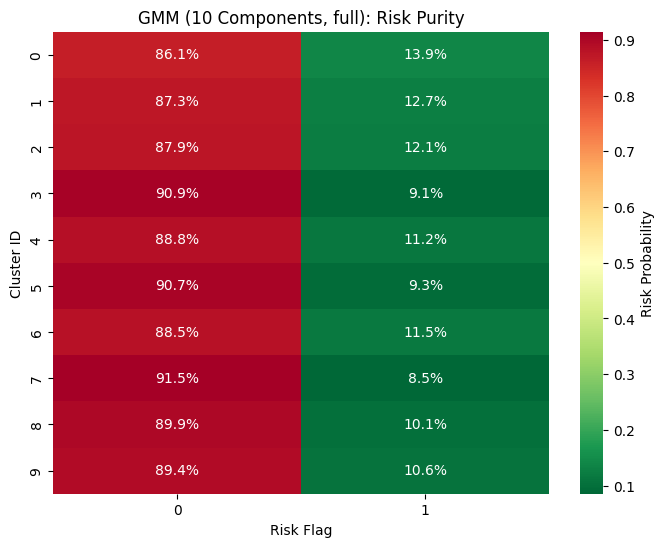

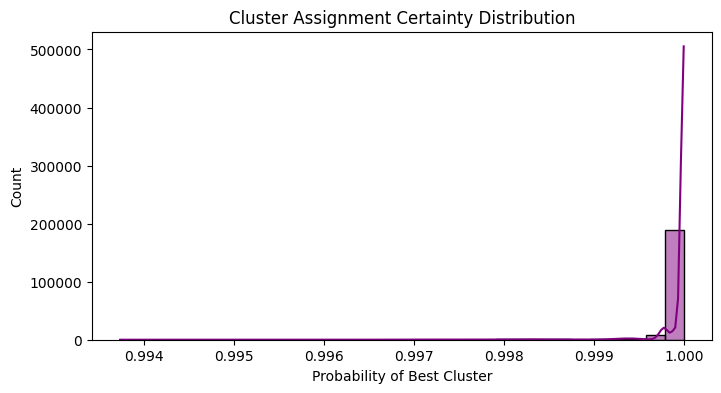

In [8]:
# --- 1. Risk Distribution Heatmap ---
# Create analysis dataframe
df_profile = pd.DataFrame({'Cluster': gmm_labels, 'Risk': y_train})

# Crosstab (Percentages)
ct_pct = pd.crosstab(df_profile['Cluster'], df_profile['Risk'], normalize='index')

print("--- Cluster Risk Probabilities ---")
print(ct_pct)

plt.figure(figsize=(8, 6))
sns.heatmap(ct_pct, annot=True, fmt='.1%', cmap='RdYlGn_r', cbar_kws={'label': 'Risk Probability'})
plt.title(f'GMM ({best_n} Components, {best_cov}): Risk Purity')
plt.ylabel('Cluster ID')
plt.xlabel('Risk Flag')
plt.show()

# --- 2. Soft Clustering Certainty ---
# How confident is the model?
probs = best_gmm.predict_proba(X_pca)
certainty = np.max(probs, axis=1) # Max prob for each point

plt.figure(figsize=(8, 4))
sns.histplot(certainty, bins=30, kde=True, color='purple')
plt.title('Cluster Assignment Certainty Distribution')
plt.xlabel('Probability of Best Cluster')
plt.ylabel('Count')
plt.show()

## 4. Submission Generation

Finally, we apply the model to the Test Set.

**Logic:**
1.  **Transform:** Apply the same Preprocessing and PCA to test data.
2.  **Predict:** Get the cluster assignment for every test applicant.
3.  **Map:** Use the **Risk Map** generated in Step 3.
    * *Example:* If Cluster 2 has 90% Risk=1 applicants, we classify all test points in Cluster 2 as Risk 1.

In [9]:
# --- 1. Prepare Test Data ---
# Preprocess Test (Assuming test dataframe is loaded)
# In practice: X_test_processed = preprocessor.transform(test)
# Using placeholder for flow:
X_test_processed = preprocessor.transform(test) 

# Apply PCA
X_test_pca = pca_opt.transform(X_test_processed)

# --- 2. Predict Clusters ---
test_clusters = best_gmm.predict(X_test_pca)

# --- 3. Create Mapping (Cluster -> Majority Risk) ---
# Find the mode (most common risk) for each cluster in training
cluster_risk_map = df_profile.groupby('Cluster')['Risk'].agg(
    lambda x: pd.Series.mode(x)[0]
).to_dict()

print(f"Risk Mapping: {cluster_risk_map}")

# --- 4. Generate Predictions ---
final_predictions = pd.Series(test_clusters).map(cluster_risk_map)

# --- 5. Save ---
submission = pd.DataFrame({
    'ProfileID': test['ProfileID'],
    'RiskFlag': final_predictions
})

submission.to_csv("submission_unsupervised_gmm.csv", index=False)
print("Saved: submission_unsupervised_gmm.csv")

Risk Mapping: {0: 0, 1: 0, 2: 0, 3: 0, 4: 0, 5: 0, 6: 0, 7: 0, 8: 0, 9: 0}
Saved: submission_unsupervised_gmm.csv
